# Scida+TNG tutorial
This notebook gives a short tutorial on some key functionality of the [scida](https://cbyrohl.github.io/scida/) library to perform TNG data analysis.

**scida** is an analysis tool for large astrophysical datasets, particularly cosmological and galaxy formation simulations.

Features:

* Unified, high-level interface to load and analyze large datasets from a variety of sources.
* Parallel, task-based data processing with dask arrays.
* Physical unit support via pint.
* Easily extensible architecture.

In [1]:
pwd

'/home/tnguser/examples'

In [2]:
# first, we install scida, by executing this cell. you must then **restart the kernel** once you have installed the package.
!pip install scida

A schematic diagram of the analysis workflow in scida is shown below. The key idea is that no data loading or computations are actually performed until the very final step, where `.compute()` is called.

![scida schematic](https://www.tng-project.org/images/scida_schematic.png)

You can now follow the official [scida tutorial](https://cbyrohl.github.io/scida/tutorial/simulations/).
**You are highly recommended to work through this tutorial before continuing**.

You can copy/paste/execute the code exactly as shown, since you have direct access to all TNG simulation data in the Lab.

---

In the following, we will reproduce some tasks performed in the [tutorial.ipynb notebook](./tutorial.ipynb). The code below is only meant to allow easier comparison original tutorial prompts. 

In [3]:
from scida import load
import matplotlib.pyplot as plt
import numpy as np

Warning! Using default configuration. Please adjust/replace in '/home/tnguser/.config/scida/config.yaml'.


In [4]:
# lets load the TNG100-3 simulation. This object will contain all snapshots, which we will pick a redshift snapshot from.
# on MPCDF systems (just like this notebook on tng-project.org) the path to flagship simulations such as TNG50, TNG100, TNG300 and Illustris is automatically discovered
# hence, we only specify the name of the simulation to fetch it!
sim = load("TNG100-3")

In [5]:
# lets fetch the snapshot at z=0
snap = sim.get_dataset(redshift=0.0)
snap  # this object contains both the group catalogs and snapshot data

ArepoSnapshotWithCosmologyMixinWithUnitMixin[source=/home/tnguser/sims.TNG/L75n455TNG/output/snapdir_099]

# Group catalog 
We can access the group and subhalo catalog as follows, note that all data is 'virtual' and will only be read once requested (which we learn later).

In [6]:
grp_cat = snap.data["Group"]
print("available group catalog fields:\n", grp_cat.keys()) 

available group catalog fields:
 ['GroupBHMass', 'GroupBHMdot', 'GroupCM', 'GroupFirstSub', 'GroupGasMetalFractions', 'GroupGasMetallicity', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupOffsetsType', 'GroupPos', 'GroupSFR', 'GroupStarMetalFractions', 'GroupStarMetallicity', 'GroupVel', 'GroupWindMass', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']


In [7]:
subhalo_cat = snap.data["Subhalo"]
print("available subhalo catalog fields:\n", subhalo_cat.keys()) 

available subhalo catalog fields:
 ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity'

In [8]:
# Lets plot the subhalo mass against its SFR, just like in the regular tutorial.ipynb file.
# scida has unit support, and its best to convert the fields to the desired units before continuing to work with them
subhalo_mass = subhalo_cat["SubhaloMassInRadType"][:,4].to("Msun").magnitude  # magnitude will give the array without units
subhalo_sfr = subhalo_cat["SubhaloSFR"].to("Msun/yr").magnitude

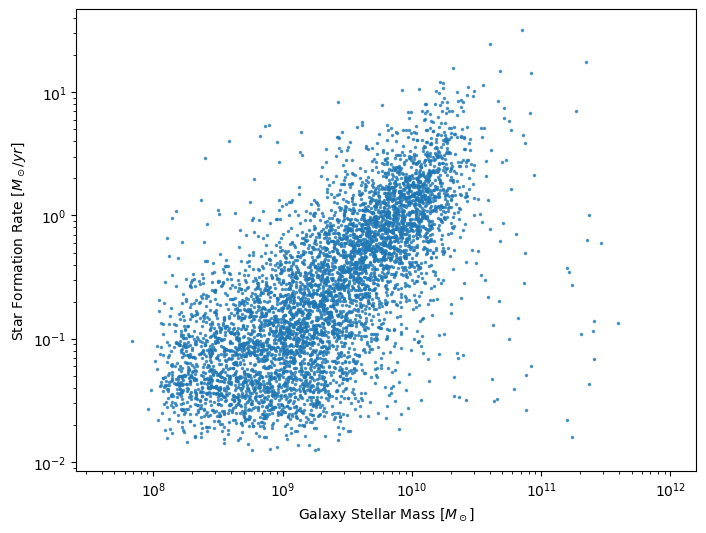

In [9]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(subhalo_mass, subhalo_sfr, '.', markersize=3.0, alpha=0.7)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Galaxy Stellar Mass [$M_\odot$]')
ax.set_ylabel('Star Formation Rate [$M_\odot / yr$]')
plt.show()

**In above plot, the calculation/fetching from disk of the respective arrays was done automatically when fed into the matplotlib plot function. Explicit calculation is explained in the [scida tutorial](https://cbyrohl.github.io/scida/tutorial/simulations/).**

# Particle data
Lets do a two-dimensional projection of the density field

In [10]:
import dask.array as da  # installed as requirement for scida, numpy-style interface

In [11]:
gas = snap.data["gas"]
print("Available gas fields:\n", gas.keys())
header = snap.header

Available gas fields:
 ['CenterOfMass', 'Coordinates', 'Density', 'ElectronAbundance', 'EnergyDissipation', 'GFM_AGNRadiation', 'GFM_CoolingRate', 'GFM_Metallicity', 'GFM_Metals', 'GFM_MetalsTagged', 'GFM_WindDMVelDisp', 'GFM_WindHostHaloMass', 'GroupFirstSub', 'GroupID', 'InternalEnergy', 'InternalEnergyOld', 'LocalSubhaloID', 'Machnumber', 'MagneticField', 'MagneticFieldDivergence', 'Masses', 'NeutralHydrogenAbundance', 'ParticleIDs', 'Potential', 'StarFormationRate', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'SubhaloID', 'Temperature', 'Velocities']


Request a `histogram2d()` calculation, summing the gas masses across the entire simulaton box:

In [12]:
x = gas['Coordinates'][:, 0]
y = gas['Coordinates'][:, 1]
weights = gas['Masses']  # if we do not convert units, then it remains as code units just as in the regular TNG tutorial
nPixels = [128, 128]
minMax = [0, header['BoxSize']]

# all arrays need to have the same chunked structure, we thus need to recast the chunk shape
# (this is the common strategy should you get "ValueError: Input arrays and weights must have the same shape and chunk structure.")
weights = weights.rechunk(x.chunks)

grid, _, _ = da.histogram2d(x, y, weights=weights, bins=nPixels, range=[minMax,minMax])
grid = grid.compute()  # do actual calculation; might take some time

Unit conversion to easily understandable units, since we initially loaded `Masses` in the (default) code units:

In [13]:
pxSize = header['BoxSize'] / nPixels[0] # code units
pxSize_kpc = pxSize * header['Time'] / header['HubbleParam']
pxArea = pxSize_kpc**2

grid_log_msun_per_kpc2 = np.log10(grid * 1e10 / header['HubbleParam'] / pxArea)

Finally, make the actual plot with the `grid_log_msun_per_kpc2` we have constructed:

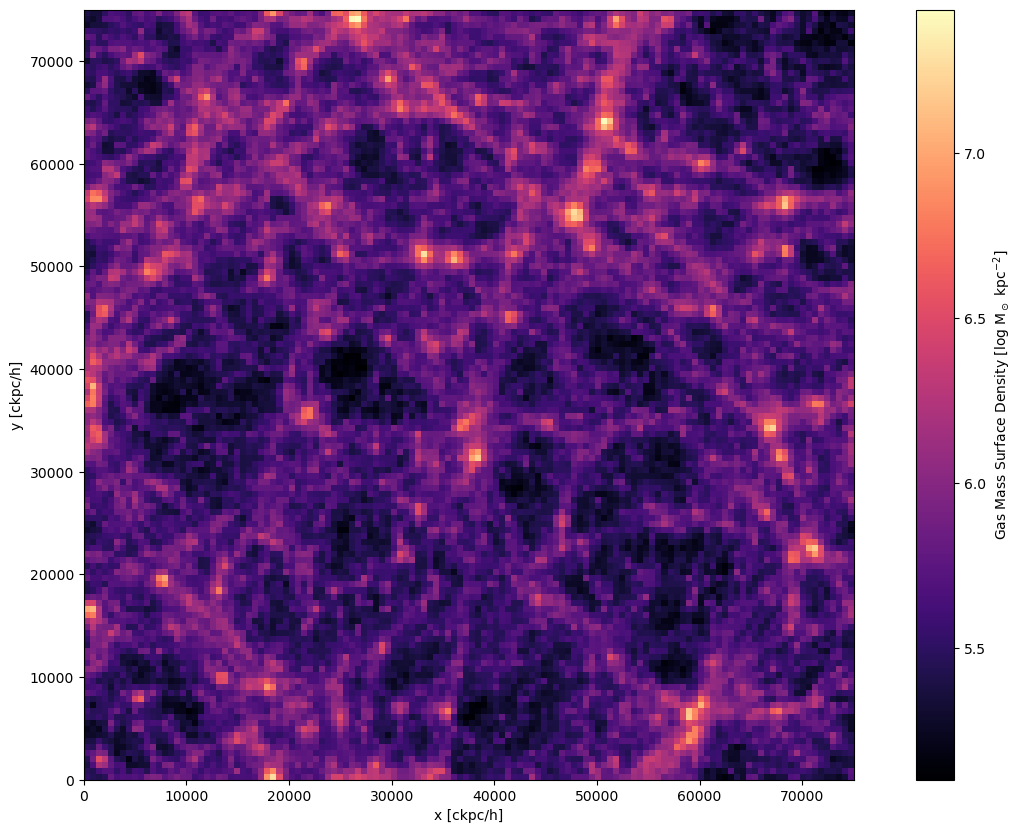

In [14]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)

extent = [0, header['BoxSize'], 0, header['BoxSize']]
plt.imshow(grid_log_msun_per_kpc2, extent=extent, cmap='magma', aspect=nPixels[1]/nPixels[0])
ax.autoscale(False)
ax.set_xlabel('x [ckpc/h]')
ax.set_ylabel('y [ckpc/h]')
plt.colorbar(label='Gas Mass Surface Density [log M$_\odot$ kpc$^{-2}$]');

The end! This was just a short intro to **scida**.

Check out the [documentation](https://cbyrohl.github.io/scida/) or [github page](https://github.com/cbyrohl/scida) for a more in-depth "getting started" guide, a cookbook of common tasks, advanced topics, and more.